<a href="https://colab.research.google.com/github/PezwariNaan/ColabLinks/blob/main/CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup

In [ ]:
!pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.4/840.4 kB 5.7 MB/s eta 0:00:00


In [ ]:
try:
  import mlxtend
  print(f"mlxtend version: {mlxtend.__version__}")
  assert int(mlxtend.__version__.split('.')[1]) >= 19, "mlxtend version must .19 or higher"
except:
  !pip install -U mlxtend
  import mlxtend
  print(f"mlxtend verision: {mlxtend.__version__}")

mlxtend version: 0.22.0


In [ ]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
import torchmetrics
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from timeit import default_timer as timer
import random
from pathlib import Path

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## DataSet

In [ ]:
training_data = datasets.FashionMNIST(
    root = "data",
    train=True,
    download=True,
    transform=ToTensor(),
    target_transform=None
)

testing_data = datasets.FashionMNIST(
    root = "data",
    train=False,
    download=True,
    transform=ToTensor()
)

class_names = training_data.classes

100%|██████████| 26421880/26421880 [00:01<00:00, 16247613.47it/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 270565.07it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 5038605.27it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 24098523.43it/s]


Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



In [ ]:
BATCH_SIZE = 32

training_dataloader = DataLoader(training_data,
                                 batch_size=BATCH_SIZE,
                                 shuffle=True)

testing_dataloader = DataLoader(testing_data,
                                batch_size = BATCH_SIZE,
                                shuffle=False)

print(f"DataLoaders: {training_dataloader, testing_dataloader}")
print(f"Length of Training Dataset: {len(training_dataloader)} In Batches of {BATCH_SIZE}")
print(f"Length of Testing Dataset: {len(testing_dataloader)} In Batches of {BATCH_SIZE}")

print(f"lenth of Training Dataset * BatchSize = {len(training_dataloader) * BATCH_SIZE}")
# Carry the 16
print(f"lenth of Testing Dataset * BatchSize = {len(testing_dataloader) * BATCH_SIZE}")

DataLoaders: (<torch.utils.data.dataloader.DataLoader object at 0x7b9bce053790>, <torch.utils.data.dataloader.DataLoader object at 0x7b9bce0538b0>)
Length of Training Dataset: 1875 In Batches of 32
Length of Testing Dataset: 313 In Batches of 32
lenth of Training Dataset * BatchSize = 60000
lenth of Testing Dataset * BatchSize = 10016


## Functions

In [ ]:
def print_train_time(start: float, end: float, device: torch.device = None):
  total_time = end - start
  print(f"Train time on {device}: {total_time:.3f} seconds")
  return total_time

In [ ]:
def make_predictions(model: nn.Module,
                     data: list,
                     device: torch.device=device):
  prediction_probabilities = []
  model.eval()
  with torch.inference_mode():
    for sample in data:
      sample = torch.unsqueeze(sample, dim=0).to(device)

      prediction_logit = model(sample)
      prediction_probability = torch.softmax(prediction_logit.squeeze(), dim=0)
      prediction_probabilities.append(prediction_probability.cpu())

  return torch.stack(prediction_probabilities)

In [ ]:
def evaluate_model(model: nn.Module,
                   data_loader: DataLoader,
                   loss_fn: nn.Module,
                   accuracy_fn,
                   device: torch.device = device):
  loss, accuracy = 0, 0
  model.eval()
  with torch.inference_mode():
    for X, y in data_loader:
      X, y = X.to(device), y.to(device)
      y_predictions = model(X)
      loss += loss_fn(y_predictions, y)
      accuracy += accuracy_fn(y_predictions.argmax(dim=1), y)*100

    accuracy /= len(data_loader)
    loss /= len(data_loader)

  return {"model_name": model.__class__.__name__,
          "model_loss": loss.item(),
          "model_accuracy": accuracy.item()}

In [ ]:
def TrainStep(model: nn.Module,
             data_loader: DataLoader,
             loss_fn: nn.Module,
             optimiser: optim.Adam,
             accuracy_fn: torchmetrics.classification,
             device: torch.device = device):
  train_loss, train_acc = 0, 0
  model.to(device)
  for batch, (X,y) in enumerate(data_loader):
    X, y = X.to(device), y.to(device)
    y_prediction = model(X)
    loss = loss_fn(y_prediction, y)
    accuracy = accuracy_fn(y_prediction.argmax(dim=1), y)*100
    train_loss += loss
    train_acc += accuracy

    # Big 3
    optimiser.zero_grad()
    loss.backward()
    optimiser.step()

  train_loss /= len(data_loader)
  train_acc /= len(data_loader)
  print(f"Training Loss: {train_loss:.5f} | Training Accuracy: {train_acc:.2f}%\n")


In [ ]:
def TestStep(model: nn.Module,
             data_loader: DataLoader,
             loss_fn: nn.Module,
             accuracy_fn: torchmetrics.classification,
             device: torch.device = device):
  test_loss, test_acc = 0, 0
  model.to(device)
  model.eval()

  with torch.inference_mode():
    for X, y in data_loader:
      X, y = X.to(device), y.to(device)

      test_prediction = model(X)

      test_loss += loss_fn(test_prediction, y)
      test_acc += accuracy_fn(test_prediction.argmax(dim=1), y)*100

    test_loss /= len(data_loader)
    test_acc /= len(data_loader)

    print(f"Test Loss: {test_loss:.5f} | Test Accuracy: {test_acc:.2f}%\n")

## Model

In [ ]:
class FashionMNISTModel(nn.Module):
  def __init__(self,
               input_shape: int,
               hidden_units: int,
               output_shape: int):

    super().__init__()
    self.block_1 = nn.Sequential(
        nn.Conv2d(in_channels=input_shape,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2)
    )

    self.block_2 = nn.Sequential(
        nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
        nn.ReLU(),
        nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2)
    )

    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units*7*7,
                  out_features=output_shape)
    )

  def forward(self, x: torch.tensor):
    x = self.block_1(x)
    x = self.block_2(x)
    x = self.classifier(x)
    return x

In [ ]:
torch.manual_seed(42)
model = FashionMNISTModel(input_shape=1,
                          hidden_units=10,
                          output_shape=len(class_names)).to(device)
model

FashionMNISTModel(
  (block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

## Stepping Through The Layers

In [ ]:
torch.manual_seed(42)

images = torch.randn(size=(32, 3, 64, 64)) # Batch size, colour channel, height, width
test_image = images[0]
print(f"Image batch shape: {images.shape}")
print(f"Single image shape: {test_image.shape}")
print(f"Single image pixel values:\n{test_image}")

Image batch shape: torch.Size([32, 3, 64, 64])
Single image shape: torch.Size([3, 64, 64])
Single image pixel values:
tensor([[[ 1.9269,  1.4873,  0.9007,  ...,  1.8446, -1.1845,  1.3835],
         [ 1.4451,  0.8564,  2.2181,  ...,  0.3399,  0.7200,  0.4114],
         [ 1.9312,  1.0119, -1.4364,  ..., -0.5558,  0.7043,  0.7099],
         ...,
         [-0.5610, -0.4830,  0.4770,  ..., -0.2713, -0.9537, -0.6737],
         [ 0.3076, -0.1277,  0.0366,  ..., -2.0060,  0.2824, -0.8111],
         [-1.5486,  0.0485, -0.7712,  ..., -0.1403,  0.9416, -0.0118]],

        [[-0.5197,  1.8524,  1.8365,  ...,  0.8935, -1.5114, -0.8515],
         [ 2.0818,  1.0677, -1.4277,  ...,  1.6612, -2.6223, -0.4319],
         [-0.1010, -0.4388, -1.9775,  ...,  0.2106,  0.2536, -0.7318],
         ...,
         [ 0.2779,  0.7342, -0.3736,  ..., -0.4601,  0.1815,  0.1850],
         [ 0.7205, -0.2833,  0.0937,  ..., -0.1002, -2.3609,  2.2465],
         [-1.3242, -0.1973,  0.2920,  ...,  0.5409,  0.6940,  1.8563]],

### Stepping Through Conv2d Layer

In [ ]:
conv_layer = nn.Conv2d(in_channels=3,
                       out_channels=10,
                       kernel_size=3,
                       stride=1,
                       padding=0)

print(conv_layer.weight.shape)
print(conv_layer.bias.shape)

torch.Size([10, 3, 3, 3])
torch.Size([10])


### Stepping Through Max Pool Layer

In [ ]:
print(f"Print Original Test Image Shape: {test_image.shape}")
print(f"Original Image Unsqueezed: {test_image.unsqueeze(dim=0).shape}")

random_tensor = torch.randn(size=(1,1,2,2,))
max_pool_layer = nn.MaxPool2d(kernel_size=2)
max_pool_tensor = max_pool_layer(random_tensor)

print(f"Random Tensor:\n{random_tensor}")
print(f"Random Tensor Shape: {random_tensor.shape}")
print(f"\nMax Pool Tensor:\n{max_pool_tensor} <- max size from random_tensor")
print(f"Max Pool Tensor Shape: {max_pool_tensor.shape}")

Print Original Test Image Shape: torch.Size([3, 64, 64])
Original Image Unsqueezed: torch.Size([1, 3, 64, 64])
Random Tensor:
tensor([[[[0.4963, 0.0045],
          [0.5534, 0.1379]]]])
Random Tensor Shape: torch.Size([1, 1, 2, 2])

Max Pool Tensor:
tensor([[[[0.5534]]]]) <- max size from random_tensor
Max Pool Tensor Shape: torch.Size([1, 1, 1, 1])


###Stepping Through Avg Pool Layer

In [ ]:
avg_pool_layer = nn.AvgPool2d(kernel_size=2)

avg_pool_tensor = avg_pool_layer(random_tensor)
torch_avg = torch.mean(random_tensor)

print(random_tensor.shape)
print(avg_pool_tensor.shape)
print(torch_avg.shape)

torch.Size([1, 1, 2, 2])
torch.Size([1, 1, 1, 1])
torch.Size([])


## Test/Train Variables

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimiser = optim.SGD(model.parameters(),
                      lr=0.1)

accuracy_fn = torchmetrics.classification.Accuracy(task="multiclass",
                                                   num_classes=len(class_names)).to(device)

## Training Loop

In [ ]:
torch.manual_seed(42)

epochs = 3
train_time_model_start = timer()
for epoch in tqdm(range(epochs)):
  print(f"Epoch {epoch}\n-----------")

  TrainStep(data_loader=training_dataloader,
            model=model,
            loss_fn=loss_fn,
            optimiser=optimiser,
            accuracy_fn=accuracy_fn,
            device=device)

  TestStep(data_loader=testing_dataloader,
           model = model,
           loss_fn=loss_fn,
           accuracy_fn=accuracy_fn,
           device=device)

train_time_model_end = timer()
train_time_total = print_train_time(start=train_time_model_start,
                                    end=train_time_model_end,
                                    device=device)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 0
-----------
Training Loss: 0.59896 | Training Accuracy: 78.38%

Test Loss: 0.39913 | Test Accuracy: 85.63%

Epoch 1
-----------
Training Loss: 0.35774 | Training Accuracy: 87.04%

Test Loss: 0.35506 | Test Accuracy: 86.90%

Epoch 2
-----------
Training Loss: 0.32308 | Training Accuracy: 88.31%

Test Loss: 0.32425 | Test Accuracy: 88.15%

Train time on cuda: 57.370 seconds


In [ ]:
model_results = evaluate_model(model=model,
                               data_loader=testing_dataloader,
                               loss_fn=loss_fn,
                               accuracy_fn=accuracy_fn)
model_results

{'model_name': 'FashionMNISTModel',
 'model_loss': 0.32425183057785034,
 'model_accuracy': 88.14895629882812}

## Making Predictions

#### Sample Predictions

In [ ]:
random.seed(42)

test_samples = []
test_labels= []
for sample, label in random.sample(list(testing_data), k=9):
  test_samples.append(sample)
  test_labels.append(label)

print(f"Test Sample Image Shape: {test_samples[0].shape}\nTest Sample Label : {test_labels[0]} ({class_names[test_labels[0]]})")

Test Sample Image Shape: torch.Size([1, 28, 28])
Test Sample Label : 5 (Sandal)


In [ ]:
prediction_probabilites = make_predictions(model=model,
                                           data=test_samples)

prediction_probabilites[:2]

tensor([[9.3802e-09, 3.0832e-09, 2.3348e-10, 8.1603e-09, 4.8914e-10, 9.9998e-01,
         5.9690e-08, 6.7094e-07, 1.3719e-06, 1.7384e-05],
        [1.4291e-01, 5.5887e-01, 2.1639e-03, 1.8107e-01, 8.2773e-02, 7.5654e-05,
         3.1858e-02, 1.1467e-04, 5.3677e-05, 1.1824e-04]])

In [ ]:
predicted_classes = prediction_probabilites.argmax(dim=1)
test_labels, predicted_classes

([5, 1, 7, 4, 3, 0, 4, 7, 1], tensor([5, 1, 7, 4, 3, 0, 4, 7, 1]))

#### Test Predictions

In [ ]:
samples = []
labels = []
for x, y in testing_data:
  samples.append(x)
  labels.append(y)


tensor([[1.8455e-06, 6.0138e-07, 2.3459e-06, 3.6359e-06, 1.1729e-06, 3.5654e-02,
         4.8826e-06, 5.1071e-02, 3.1925e-04, 9.1294e-01],
        [2.1699e-03, 8.9151e-07, 9.8694e-01, 2.8367e-04, 3.9275e-03, 2.5434e-07,
         6.6751e-03, 8.4409e-08, 6.6587e-06, 3.6875e-07]])

In [ ]:
test_predictions = make_predictions(data=samples,
                 model=model)

test_predictions[:2]

tensor([[1.8455e-06, 6.0138e-07, 2.3459e-06, 3.6359e-06, 1.1729e-06, 3.5654e-02,
         4.8826e-06, 5.1071e-02, 3.1925e-04, 9.1294e-01],
        [2.1699e-03, 8.9151e-07, 9.8694e-01, 2.8367e-04, 3.9275e-03, 2.5434e-07,
         6.6751e-03, 8.4409e-08, 6.6587e-06, 3.6875e-07]])

#### Plotting Predictions

9


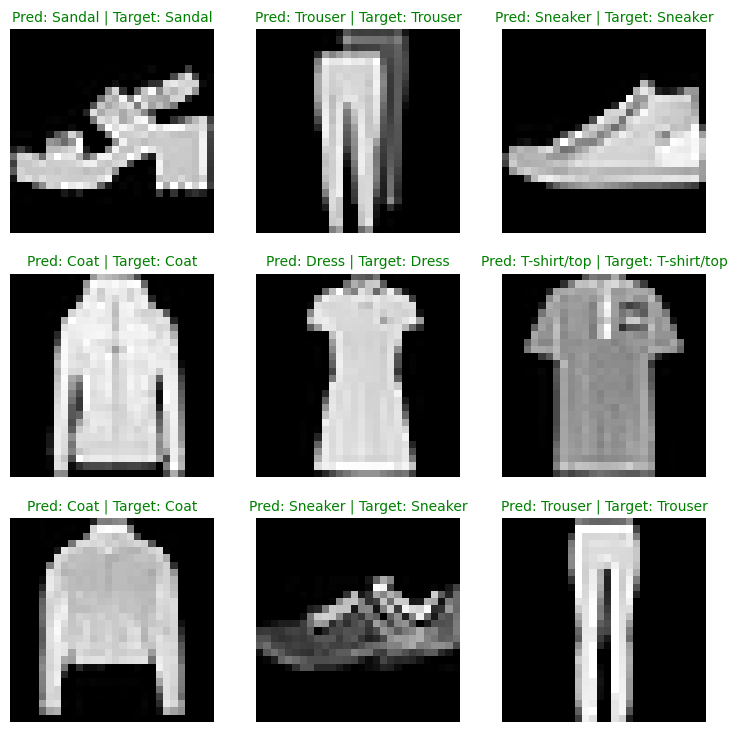

In [ ]:
plt.figure(figsize=(9, 9))
nrows = 3
ncols = 3

for i, sample in enumerate(test_samples):
  plt.subplot(nrows, ncols, i+1)

  plt.imshow(sample.squeeze(), cmap="gray")

  predicted_label = class_names[predicted_classes[i]]

  truth_label = class_names[test_labels[i]]

  title_text = f"Pred: {predicted_label} | Target: {truth_label}"

  if predicted_label == truth_label:
    plt.title(title_text, fontsize=10, c="g")
  else:
    plt.title(title_text, fontsize=10, c="r")

  plt.axis(False)


## Confusion Matrix

In [ ]:
y_predictions = []
model.eval()

with torch.inference_mode():
  for X, y in tqdm(testing_dataloader, desc="Making Predictions"):
    X, y = X.to(device),y.to(device)

    y_logit = model(X)

    y_prediction = torch.softmax(y_logit, dim=1).argmax(dim=1)

    y_predictions.append(y_prediction.cpu())

y_prediction_tensor = torch.cat(y_predictions)

Making Predictions:   0%|          | 0/313 [00:00<?, ?it/s]

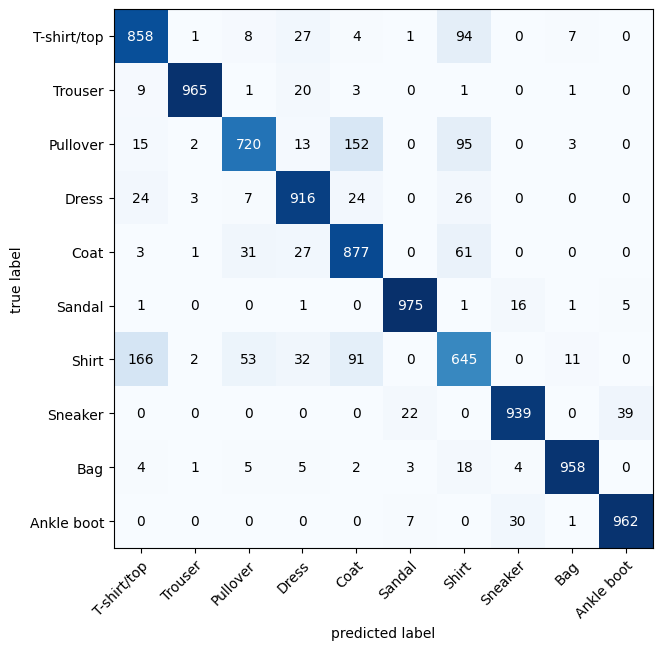

In [ ]:
confusion_matrix = ConfusionMatrix(num_classes=len(class_names),
                                   task="multiclass")
confusion_matrix_tensor = confusion_matrix(preds=y_prediction_tensor,
                                          target=testing_data.targets)

figure, axis = plot_confusion_matrix(
    conf_mat=confusion_matrix_tensor.numpy(),
    class_names=class_names,
    figsize=(10,7)
)

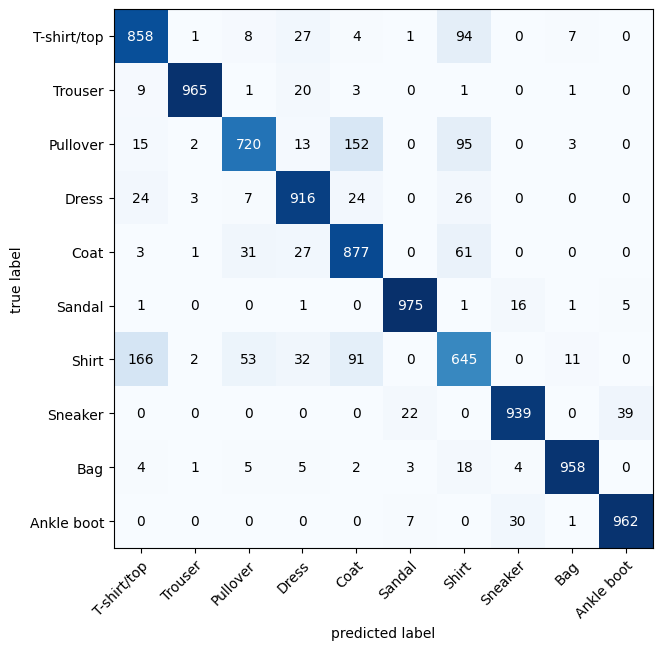

In [ ]:
confusion_matrix_test = ConfusionMatrix(num_classes=len(class_names),
                                        task="multiclass")

confusion_matrix_tensor_test = confusion_matrix_test(preds=test_predictions,
                                                     target=testing_data.targets)

figure, axis = plot_confusion_matrix(
    conf_mat=confusion_matrix_tensor_test.numpy(),
    class_names=class_names,
    figsize=(10,7)
)

## Save / Load Model

In [ ]:
MODEL_PATH = Path("Model")
MODEL_PATH.mkdir(parents=True,
                 exist_ok=True)

MODEL_NAME = "03_CNN.pth"
MODEL_SAVE_PATH = MODEL_PATH  /  MODEL_NAME

print(f"Saving Model To: {MODEL_SAVE_PATH}")
torch.save(obj=model.state_dict(),
           f=MODEL_SAVE_PATH)

In [ ]:
loaded_model = FashionMNISTModel(input_shape=1,
                                 hidden_units=10,
                                 output_shape=10)

loaded_model.load_state_dict(torch.load(f=MODEL_SAVE_PATH))
loaded_model = loaded_model.to(device)

In [ ]:
torch.manual_seed(42)

loaded_model_results = evaluate_model(model=loaded_model,
                                      data_loader=testing_dataloader,
                                      loss_fn=loss_fn,
                                      accuracy_fn=accuracy_fn)

loaded_model_results

In [ ]:
torch.isclose(torch.tensor(model_results["model_loss"]),
              torch.tensor(loaded_model_results["model_loss"]),
              atol=1e-08,
              rtol=0.0001)